# Main 

In [1]:
from transformers import GPT2Model, GPT2Tokenizer
import torch
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
import torch.nn as nn
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader
from transformers import AdamW


In [2]:

model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2Model.from_pretrained(model_name)

print(model)


/Users/varchitalalwani/miniconda3/envs/eolearn/lib/python3.9/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)


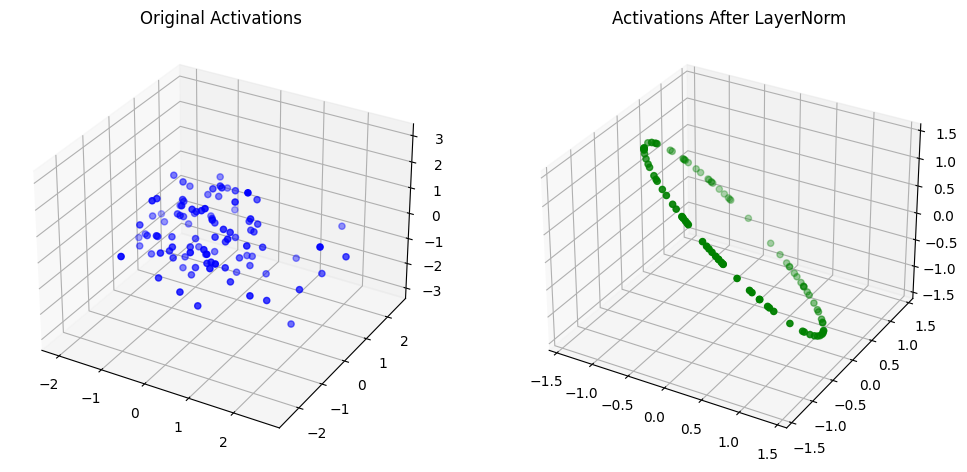

In [3]:



original_activations = np.random.randn(100, 3)  # 100 samples in 3D

# LayerNorm by formula
mean = original_activations.mean(axis=1, keepdims=True)  # Subtract mean
centered_activations = original_activations - mean
variance = centered_activations.var(axis=1, keepdims=True)
normalized_activations = centered_activations / np.sqrt(variance + 1e-5)  # Normalize to unit variance

# plot for before and after LayerNorm
fig = plt.figure(figsize=(12, 6))

# Original 
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(original_activations[:, 0], original_activations[:, 1], original_activations[:, 2], color='blue')
ax1.set_title("Original Activations")

# After LayerNorm
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(normalized_activations[:, 0], normalized_activations[:, 1], normalized_activations[:, 2], color='green')
ax2.set_title("Activations After LayerNorm")

plt.show()


In [4]:
original_means = np.mean(original_activations, axis=1)
normalized_means = np.mean(normalized_activations, axis=1)

original_norms = np.linalg.norm(original_activations, axis=1)
normalized_norms = np.linalg.norm(normalized_activations, axis=1)

print(f"Original Means: Mean={original_means.mean():.4f}, Std={original_means.std():.4f}")
print(f"Normalized Means: Mean={normalized_means.mean():.4f}, Std={normalized_means.std():.4f}")

print(f"Original Norms: Mean={original_norms.mean():.4f}, Std={original_norms.std():.4f}")
print(f"Normalized Norms: Mean={normalized_norms.mean():.4f}, Std={normalized_norms.std():.4f}")


Original Means: Mean=-0.0314, Std=0.4833
Normalized Means: Mean=0.0000, Std=0.0000
Original Norms: Mean=1.5291, Std=0.6270
Normalized Norms: Mean=1.7320, Std=0.0001


In [5]:


model = GPT2Model.from_pretrained("gpt2", output_hidden_states=True)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

text = "The girl is "
inputs = tokenizer(text, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

hidden_states = outputs.hidden_states  

transformer_block = model.h[0]  
ln_1 = transformer_block.ln_1  

residual_activations = hidden_states[1]  
normalized_activations = ln_1(residual_activations)  

centered_activations = residual_activations - residual_activations.mean(dim=-1, keepdim=True)
norms_before = torch.norm(centered_activations, dim=-1)
norms_after = torch.norm(normalized_activations, dim=-1)

print(f"Norms Before LayerNorm: Mean={norms_before.mean():.4f}, Std={norms_before.std():.4f}")
print(f"Norms After LayerNorm: Mean={norms_after.mean():.4f}, Std={norms_after.std():.4f}")


Norms Before LayerNorm: Mean=75.6745, Std=38.1015
Norms After LayerNorm: Mean=4.5556, Std=0.1051


In [6]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

model = GPT2LMHeadModel.from_pretrained("gpt2")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

text = "The girl is playing with the"

inputs = tokenizer(text, return_tensors="pt")

outputs = model.generate(
    inputs['input_ids'],
    max_length=50,
    num_return_sequences=1,
    temperature=0.7,  
    top_k=5,         
    top_p=0.9
)

predicted_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(predicted_text)


/Users/varchitalalwani/miniconda3/envs/eolearn/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/Users/varchitalalwani/miniconda3/envs/eolearn/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/Users/varchitalalwani/miniconda3/envs/eolearn/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:509: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.war

The girl is playing with the toy, and the toy is a toy.

The girl is playing with the toy, and the toy is a toy. The girl is playing with the toy, and the toy is a toy. The girl is


In [7]:


model = GPT2LMHeadModel.from_pretrained("gpt2", output_hidden_states=True)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

text = "The girl is playing with the"
inputs = tokenizer(text, return_tensors="pt")

class BypassLayerNorm(torch.nn.Module):
    def forward(self, x):
        return x  

norm_stats = [] 
original_ln_modules = []  

for i, transformer_block in enumerate(model.transformer.h):
    ln_1 = transformer_block.ln_1

    original_ln_modules.append(ln_1)

    with torch.no_grad():
        outputs_with_ln = model(inputs["input_ids"], output_hidden_states=True)

    hidden_states_with_ln = outputs_with_ln.hidden_states[i + 1]  # Hidden states after the i-th layer

    mean_before = hidden_states_with_ln.mean(dim=-1).detach().cpu().numpy()  # Mean across the hidden dimension
    std_before = hidden_states_with_ln.std(dim=-1).detach().cpu().numpy()  # Std across the hidden dimension

    normalized_activations = ln_1(hidden_states_with_ln)
    mean_after = normalized_activations.mean(dim=-1).detach().cpu().numpy()
    std_after = normalized_activations.std(dim=-1).detach().cpu().numpy()

    transformer_block.ln_1 = BypassLayerNorm()

    with torch.no_grad():
        outputs_without_ln = model.generate(
            inputs["input_ids"],
            max_length=50,
            temperature=0.7,
            top_k=50,
            top_p=0.9,
            num_return_sequences=1,
        )

    transformer_block.ln_1 = original_ln_modules[i]

    predicted_output_with_ln = tokenizer.decode(outputs_with_ln.logits[0].argmax(dim=-1), skip_special_tokens=True)
    predicted_output_without_ln = tokenizer.decode(outputs_without_ln[0], skip_special_tokens=True)

    norm_stats.append({
        "layer": i + 1,
        "mean_before": np.mean(mean_before),
        "std_before": np.mean(std_before),
        "mean_after": np.mean(mean_after),
        "std_after": np.mean(std_after),
    })

    print(f"Layer {i + 1}:")
    print(f"Norm Stats Before LayerNorm - Mean: {np.mean(mean_before):.4f}, Std: {np.mean(std_before):.4f}")
    print(f"Norm Stats After LayerNorm  - Mean: {np.mean(mean_after):.4f}, Std: {np.mean(std_after):.4f}")
    print(f"Predicted Output With LayerNorm: {predicted_output_with_ln}")
    print(f"Predicted Output Without LayerNorm: {predicted_output_without_ln}")
    print("-" * 50)

print("Summary of Norm Statistics:")
for stat in norm_stats:
    print(f"Layer {stat['layer']}: Mean Before={stat['mean_before']:.4f}, Std Before={stat['std_before']:.4f}, "
          f"Mean After={stat['mean_after']:.4f}, Std After={stat['std_after']:.4f}")


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Layer 1:
Norm Stats Before LayerNorm - Mean: 0.0458, Std: 2.5089
Norm Stats After LayerNorm  - Mean: -0.0062, Std: 0.1627
Predicted Output With LayerNorm: 
 was a with a toy
Predicted Output Without LayerNorm: The girl is playing with the. the. the..
 the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Layer 2:
Norm Stats Before LayerNorm - Mean: 0.1743, Std: 5.5171
Norm Stats After LayerNorm  - Mean: -0.0060, Std: 0.1431
Predicted Output With LayerNorm: 
 was a with a toy
Predicted Output Without LayerNorm: The girl is playing with the-, and and and other- and- ­----- andcom---, and and, subject,..
SC and,,,,,,,,,,,,
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Layer 3:
Norm Stats Before LayerNorm - Mean: 0.6950, Std: 17.2571
Norm Stats After LayerNorm  - Mean: -0.0013, Std: 0.2317
Predicted Output With LayerNorm: 
 was a with a toy
Predicted Output Without LayerNorm: The girl is playing with the
…)
…)
…)'"""


































--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Layer 4:
Norm Stats Before LayerNorm - Mean: 0.7488, Std: 18.5589
Norm Stats After LayerNorm  - Mean: -0.0003, Std: 0.2800
Predicted Output With LayerNorm: 
 was a with a toy
Predicted Output Without LayerNorm: The girl is playing with the��������������������������������������������
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Layer 5:
Norm Stats Before LayerNorm - Mean: 0.7919, Std: 19.6664
Norm Stats After LayerNorm  - Mean: 0.0022, Std: 0.2605
Predicted Output With LayerNorm: 
 was a with a toy
Predicted Output Without LayerNorm: The girl is playing with the canal canal canal canal canal canal canal canal canal canal canal canal canal canal canal canal canal canal canal canal canal canal canal canal canal canal canal canal canal canal canal canal canal canal canal canal canal canal canal canal canal canal canal canal
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Layer 6:
Norm Stats Before LayerNorm - Mean: 0.8203, Std: 20.3676
Norm Stats After LayerNorm  - Mean: 0.0065, Std: 0.3166
Predicted Output With LayerNorm: 
 was a with a toy
Predicted Output Without LayerNorm: The girl is playing with theeteriaeteriaeteriaeteriaeteriaeteriaeteriaeteriaeteriaeteriaeteriaeteriaeteriaeteriaeteriaeteriaeteriaeteriaeteriaeteriaeteriaeteriaeteriaeteriaeteriaeteriaeteriaeteriaeteriaeteriaeteriaeteriaeteriaeteriaeteriaeteriaeteriaeteriaeteriaeteriaeteriaeteriaeteriaeteria
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Layer 7:
Norm Stats Before LayerNorm - Mean: 0.8501, Std: 21.0366
Norm Stats After LayerNorm  - Mean: 0.0057, Std: 0.2842
Predicted Output With LayerNorm: 
 was a with a toy
Predicted Output Without LayerNorm: The girl is playing with the,,,,,,,,,,,,,,,,,,,,-|,,,,,,,,,,,,,,,,,,,,,,-|
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Layer 8:
Norm Stats Before LayerNorm - Mean: 0.8843, Std: 21.7386
Norm Stats After LayerNorm  - Mean: 0.0077, Std: 0.2728
Predicted Output With LayerNorm: 
 was a with a toy
Predicted Output Without LayerNorm: The girl is playing with the,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Layer 9:
Norm Stats Before LayerNorm - Mean: 0.9092, Std: 22.5777
Norm Stats After LayerNorm  - Mean: 0.0070, Std: 0.2516
Predicted Output With LayerNorm: 
 was a with a toy
Predicted Output Without LayerNorm: The girl is playing with the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Layer 10:
Norm Stats Before LayerNorm - Mean: 0.9318, Std: 23.6858
Norm Stats After LayerNorm  - Mean: 0.0104, Std: 0.2355
Predicted Output With LayerNorm: 
 was a with a toy
Predicted Output Without LayerNorm: The girl is playing with the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
--------------------------------------------------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Layer 11:
Norm Stats Before LayerNorm - Mean: 1.0368, Std: 26.4816
Norm Stats After LayerNorm  - Mean: 0.0126, Std: 0.1970
Predicted Output With LayerNorm: 
 was a with a toy
Predicted Output Without LayerNorm: The girl is playing with the,,,,,,,,,,,,,,,,,,,,,, disabled,,,,, disabled, disabled, disabled, disabled, disabled, disabled, disabled, disabled,
--------------------------------------------------
Layer 12:
Norm Stats Before LayerNorm - Mean: 0.3196, Std: 7.6332
Norm Stats After LayerNorm  - Mean: 0.0113, Std: 0.2261
Predicted Output With LayerNorm: 
 was a with a toy
Predicted Output Without LayerNorm: The girl is playing with the,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
--------------------------------------------------
Summary of Norm Statistics:
Layer 1: Mean Before=0.0458, Std Before=2.5089, Mean After=-0.0062, Std After=0.1627
Layer 2: Mean Before=0.1743, Std Before=5.5171, Mean After=-0.0060, Std After=0.1431
Layer 3: Mean Before=0.6950, Std Before=17.2571, Mean After=-

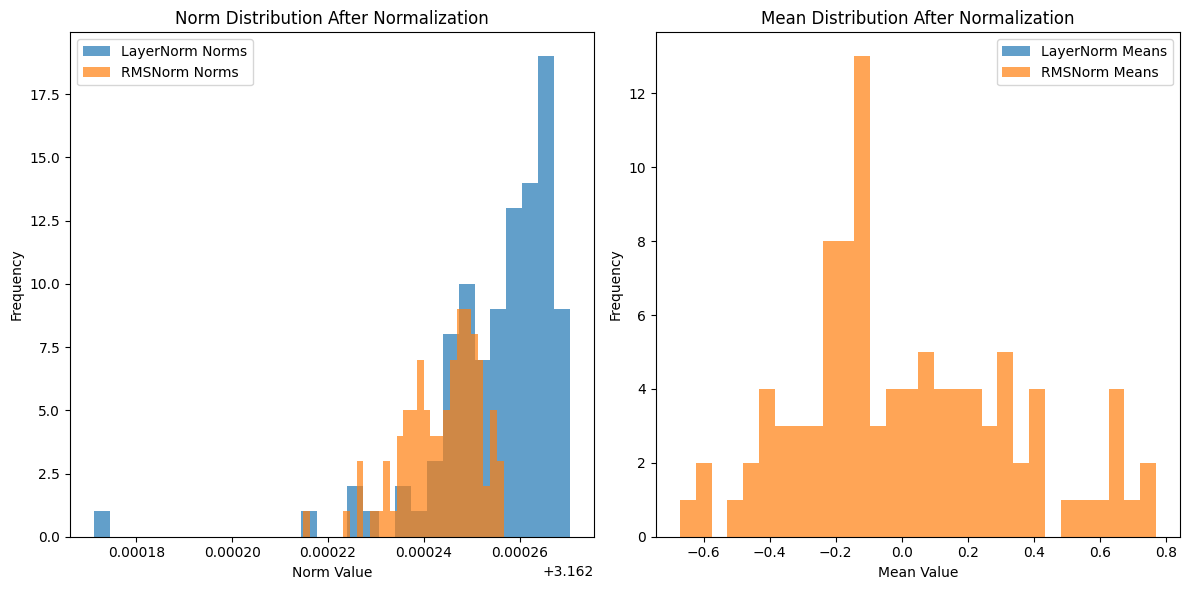

In [8]:


class CustomLayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-5):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        return self.gamma * (x - mean) / torch.sqrt(var + self.eps) + self.beta

class RMSNorm(nn.Module):
    def __init__(self, d_model, eps=1e-5):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.eps = eps

    def forward(self, x):
        rms = torch.sqrt(torch.mean(x**2, dim=-1, keepdim=True))
        return self.gamma * x / (rms + self.eps)

torch.manual_seed(42)
data = torch.randn(100, 10)  # 100 samples, 10-dimensional vectors

layernorm = CustomLayerNorm(d_model=10)
layernorm_output = layernorm(data)

rmsnorm = RMSNorm(d_model=10)
rmsnorm_output = rmsnorm(data)

ln_norms = torch.norm(layernorm_output, dim=-1).detach().cpu().numpy()
rms_norms = torch.norm(rmsnorm_output, dim=-1).detach().cpu().numpy()

ln_means = layernorm_output.mean(dim=-1).detach().cpu().numpy()
rms_means = rmsnorm_output.mean(dim=-1).detach().cpu().numpy()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(ln_norms, bins=30, alpha=0.7, label="LayerNorm Norms")
plt.hist(rms_norms, bins=30, alpha=0.7, label="RMSNorm Norms")
plt.title("Norm Distribution After Normalization")
plt.xlabel("Norm Value")
plt.ylabel("Frequency")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(ln_means, bins=30, alpha=0.7, label="LayerNorm Means")
plt.hist(rms_means, bins=30, alpha=0.7, label="RMSNorm Means")
plt.title("Mean Distribution After Normalization")
plt.xlabel("Mean Value")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()


In [9]:

print("LayerNorm:")
print(f"Mean of Means: {ln_means.mean():.4f}, Std of Means: {ln_means.std():.4f}")
print(f"Mean of Norms: {ln_norms.mean():.4f}, Std of Norms: {ln_norms.std():.4f}")

print("\nRMSNorm:")
print(f"Mean of Means: {rms_means.mean():.4f}, Std of Means: {rms_means.std():.4f}")
print(f"Mean of Norms: {rms_norms.mean():.4f}, Std of Norms: {rms_norms.std():.4f}")


LayerNorm:
Mean of Means: -0.0000, Std of Means: 0.0000
Mean of Norms: 3.1623, Std of Norms: 0.0000

RMSNorm:
Mean of Means: 0.0100, Std of Means: 0.3230
Mean of Norms: 3.1622, Std of Norms: 0.0000


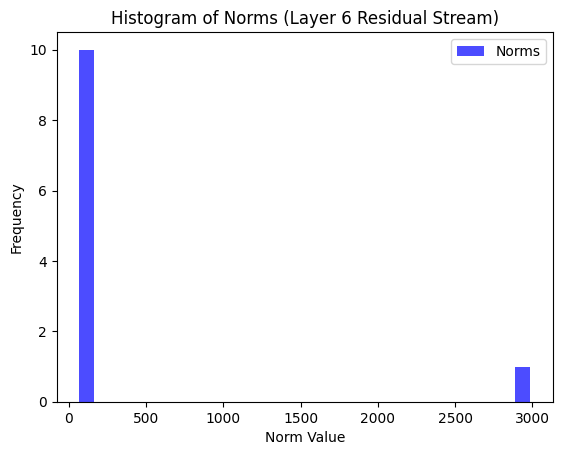

Average Norm: 341.6330
Variance of Norms: 770270.6250


In [10]:
from transformers import GPT2Model, GPT2Tokenizer
import torch
import numpy as np
import matplotlib.pyplot as plt

# Load GPT-2 small model and tokenizer
model = GPT2Model.from_pretrained("gpt2", output_hidden_states=True)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Define input text
text = "The girl is playing with the ball in the park."
inputs = tokenizer(text, return_tensors="pt")

# Perform forward pass
with torch.no_grad():
    outputs = model(**inputs)

# Extract hidden states (residual stream outputs)
hidden_states = outputs.hidden_states  # Tuple of hidden states for each layer

# Extract activations after layer 6
layer_6_activations = hidden_states[6]  # Shape: (batch_size, seq_length, hidden_size)

# Subtract mean activation for each vector (mean over the hidden dimension)
mean_subtracted_activations = layer_6_activations - layer_6_activations.mean(dim=-1, keepdim=True)

# Compute norms for each token (over the hidden dimension)
norms = torch.norm(mean_subtracted_activations, dim=-1)  # Shape: (batch_size, seq_length)

# Calculate average norm and variance
average_norm = norms.mean().item()
variance_norm = norms.var().item()

# Plot histogram of norms
norms_np = norms.flatten().cpu().numpy()  # Flatten for histogram
plt.hist(norms_np, bins=30, alpha=0.7, color='blue', label="Norms")
plt.title("Histogram of Norms (Layer 6 Residual Stream)")
plt.xlabel("Norm Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Print statistics
print(f"Average Norm: {average_norm:.4f}")
print(f"Variance of Norms: {variance_norm:.4f}")


# Rough/extra/trial


In [11]:
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")
train_texts = dataset['train']['text'][:100] 

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2", output_hidden_states=True)
model.train()  


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [12]:
layernorm_activations = []

def hook(module, inputs, outputs):
    layernorm_activations.append(outputs.detach()) 

model.transformer.h[0].ln_1.register_forward_hook(hook)


In [13]:
from torch.utils.data import DataLoader
from transformers import AdamW

filtered_texts = [text for text in train_texts if len(text.strip()) > 0]

def tokenize(batch):
    tokenizer.pad_token = tokenizer.eos_token  # Assign a padding token
    return tokenizer(batch, truncation=True, padding="max_length", max_length=50, return_tensors="pt")

tokenized_texts = [tokenize(text) for text in filtered_texts]

dataloader = DataLoader(tokenized_texts, batch_size=4, collate_fn=lambda x: x)

optimizer = AdamW(model.parameters(), lr=5e-5)

for batch in dataloader:
    inputs = {k: torch.cat([item[k] for item in batch], dim=0) for k in batch[0].keys()}
    outputs = model(**inputs, labels=inputs['input_ids'])

    loss = outputs.loss
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

print("Fine-tuning completed.")


/Users/varchitalalwani/miniconda3/envs/eolearn/lib/python3.9/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Fine-tuning completed.


Epoch 1/3
Epoch 1 Loss: 48.6171
Epoch 2/3
Epoch 2 Loss: 37.7136
Epoch 3/3
Epoch 3 Loss: 30.3628
Fine-tuning completed.


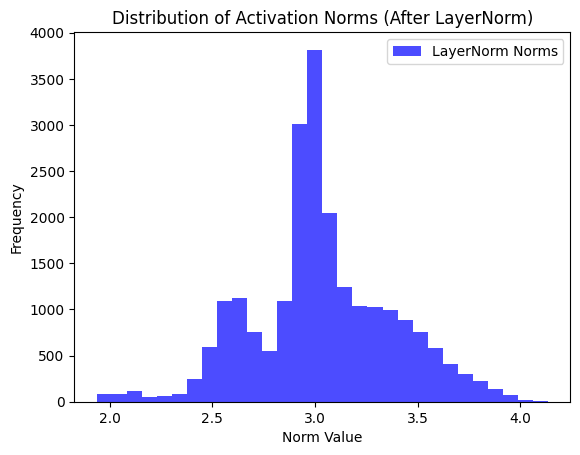

In [14]:


filtered_texts = [text for text in train_texts if len(text.strip()) > 0]

def tokenize(batch):
    tokenizer.pad_token = tokenizer.eos_token  # Assign a padding token
    return tokenizer(batch, truncation=True, padding="max_length", max_length=50, return_tensors="pt")

tokenized_texts = [tokenize(text) for text in filtered_texts]

dataloader = DataLoader(tokenized_texts, batch_size=4, collate_fn=lambda x: x)

optimizer = AdamW(model.parameters(), lr=5e-5)

layernorm_activations = []

def hook(module, inputs, outputs):
    layernorm_activations.append(outputs.detach())

model.transformer.h[0].ln_1.register_forward_hook(hook)

epochs = 3  
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    epoch_loss = 0

    for batch in dataloader:
        inputs = {k: torch.cat([item[k] for item in batch], dim=0) for k in batch[0].keys()}

        outputs = model(**inputs, labels=inputs['input_ids'])
        loss = outputs.loss
        epoch_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f"Epoch {epoch + 1} Loss: {epoch_loss:.4f}")

print("Fine-tuning completed.")

if layernorm_activations:
    activations = torch.cat(layernorm_activations, dim=0).cpu().numpy()

    mean_activations = activations.mean(axis=-1, keepdims=True)
    centered_activations = activations - mean_activations
    norms = np.linalg.norm(centered_activations, axis=-1)
    norms = norms.flatten()
    
    plt.hist(norms, bins=30, alpha=0.7, color='blue', label='LayerNorm Norms')
    plt.title("Distribution of Activation Norms (After LayerNorm)")
    plt.xlabel("Norm Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()


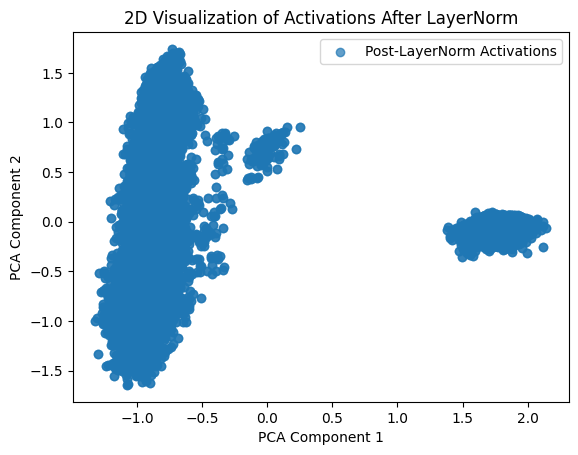

In [15]:
activations_reshaped = activations.reshape(-1, activations.shape[-1])

pca = PCA(n_components=2)
activations_2d = pca.fit_transform(activations_reshaped)

plt.scatter(activations_2d[:, 0], activations_2d[:, 1], alpha=0.7, label="Post-LayerNorm Activations")
plt.title("2D Visualization of Activations After LayerNorm")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()


In [16]:
from torch.utils.data import DataLoader
from transformers import AdamW
import torch
import matplotlib.pyplot as plt

class BypassLayerNorm(torch.nn.Module):
    def forward(self, x):
        return x  
    
for layer in model.transformer.h:
    layer.ln_1 = BypassLayerNorm()
    layer.ln_2 = BypassLayerNorm()

print("Deactivated all LayerNorm layers in the model.")

filtered_texts = [text for text in train_texts if len(text.strip()) > 0]

def tokenize(batch):
    tokenizer.pad_token = tokenizer.eos_token 
    return tokenizer(batch, truncation=True, padding="max_length", max_length=50, return_tensors="pt")

tokenized_texts = [tokenize(text) for text in filtered_texts]
dataloader = DataLoader(tokenized_texts, batch_size=4, collate_fn=lambda x: x)

optimizer = AdamW(model.parameters(), lr=5e-5)

epochs = 3 
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    epoch_loss = 0

    for batch in dataloader:
        inputs = {k: torch.cat([item[k] for item in batch], dim=0) for k in batch[0].keys()}

        outputs = model(**inputs, labels=inputs['input_ids'])
        loss = outputs.loss
        epoch_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f"Epoch {epoch + 1} Loss: {epoch_loss:.4f}")

print("Fine-tuning completed.")


Deactivated all LayerNorm layers in the model.
Epoch 1/3


/Users/varchitalalwani/miniconda3/envs/eolearn/lib/python3.9/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 Loss: nan
Epoch 2/3
Epoch 2 Loss: nan
Epoch 3/3
Epoch 3 Loss: nan
Fine-tuning completed.
